# DS4DS Homework Exercise Sheet 11

**General Instructions:**

- Collaborations between students during problem-solving phase on a discussion basis is OK
- However: individual code programming and submissions per student are required
- Code sharing is strictly prohibited
- We will run checks for shared code, general plagiarism and AI-generated solutions
- Any fraud attempt will lead to an auto fail of the entire course
- Do not use any additional packages except for those provided in the task templates
- Please use Julia Version 1.10.x to ensure compatibility
- Please only write between the `#--- YOUR CODE STARTS HERE ---#` and `#--- YOUR CODE ENDS HERE ---#` comments
- Please do not delete, add any cells or overwrite cells other than the solution cells (**Tip:** If you use a jupyerhub IDE, you should not be able to add or delete cells and write in the non-solution cells by default)

In [1]:
using Printf
using DelimitedFiles, Plots, GZip, StatsBase, LaTeXStrings, Serialization
using OrdinaryDiffEq, Lux, Random, ComponentArrays
using DataInterpolations, SciMLSensitivity, Optimization, OptimizationOptimJL, LineSearches, Zygote, OptimizationFlux, Flux

## Task 1: NODE model for a SISO heating system - (6 points)

In this task, we consider a simple single-input-single-output (SISO) heating system. The input of the system $u(t)$ is the voltage that drives a  halogen lamp which is suspended several inches above a thin steel plate. The output of the system $y(t)$ is a thermocouple measurement taken from the back of the plate ([source](https://ftp.esat.kuleuven.be/pub/SISTA/data/thermic/) and [description](https://ftp.esat.kuleuven.be/pub/SISTA/data/thermic/heating_system.txt) of the dataset).

Our goal within this task will be to identify the dynamics of the underlying process. We make the assumption that the temperature measurment holds sufficient information to characterize the process, i.e., that $\hat{x}(t) = \hat{y}(t)$ applies. We will build a model

$$
\begin{align}
    \frac{\mathrm{d}}{\mathrm{d}t} \hat{x}(t) &= \mathcal{M}_{\mathbf{w}} (\hat{x}(t), u(t)) \\
    \hat{y}(t) & = \hat{x} (t)
\end{align}
$$

that estimates the change of temperature. To this end, we will make use of neural ordinary differential equations (NODEs).

The basic idea of NODEs is to use an artifical neural network (ANN) to model the state transition equation $\frac{\mathrm{d}}{\mathrm{d}t} \hat{x}(t) = \mathcal{M}_{\mathbf{w}} (\hat{x}(t), u(t))$ that is parameterized by $\mathbf{w}$. The resulting ODE is then solved by standard ODE solvers to yield an estimate for the state trajectory. This estimated state trajectory is then compared to the target trajectory to optimize the parameters in the ANN and improve the approximation.

#### Function for dataset loading:

In [2]:
function loaddata_heating(; normalize=true)
    fh = GZip.open("heating_system.dat.gz")
    data = readdlm(fh)

    data_freq = 4
    
    data = data[1:data_freq:end, :]
    
    t = data[:, 1] / 16  # time in seconds
    u = data[:, 2]  # input: voltage driving the lamp in volt
    y = data[:, 3]  # output: temperature measurement in °C

    
    dt = 2 * data_freq / 16  # time between samples in seconds (thermic process -> high inertia)
    
    # convert to Float32 for performance
    t = Float32.(t)
    u = Float32.(u) 
    y = Float32.(y)
    
    if normalize  # optional standardization of data
        dty = fit(ZScoreTransform, y)
        dtu = fit(ZScoreTransform, u)
    
        y = StatsBase.transform(dty, y)
        u = StatsBase.transform(dtu, u);
    end
    
    tspan = (t[1], t[end])
    
    return u, y, dt, tspan, t
end

loaddata_heating (generic function with 1 method)

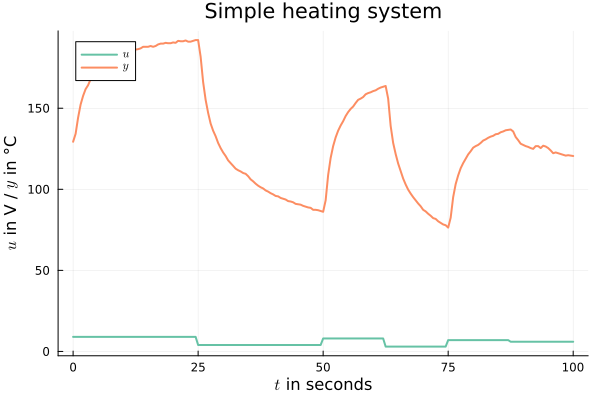

In [3]:
u, y, dt, tspan, tsteps = loaddata_heating(normalize = false)
p = plot(tsteps, u, label=L"u", title="Simple heating system", xlabel=L"$t$ in seconds", ylabel=L"$u$ in V / $y$ in °C",
     legend=:topleft, lw=2, palette = :Set2_5)
plot!(p, tsteps, y, label=L"y", lw =2)

#### **a)** - (0.5 point)
Split your dataset into a training and evaluation dataset. The training dataset will be used to tune the parameters of your model and the evaluation data will be used to evaluate the generalization performance of your model.
Use $u(t >= 37.5s)$ and $y(t >= 37.5s)$ for the training and $u(t < 37.5s)$ and $y(t < 37.5s)$ for the evaluation datasets. Additionally, provide the corresponding timesteps for the training and eval datasets, i.e., provide
```tsteps_training``` which contains all timesteps from the dataset with $t >= 37.5s$ and ```tsteps_eval``` which contains all timesteps with $t < 37.5s$.

Implement the function below to split the dataset.

In [4]:
u, y, dt, tspan, tsteps = loaddata_heating();

function split_dataset(u, y, tsteps)
    """
    Creates a training and evaluation split
    
    Args:
        u: System input data
        y: System output data
        tsteps: time steps of the data trajectories

    Returns:
        u_training: u(t >= 37.5s)
        y_training: y(t >= 37.5s)
        u_eval: u(t < 37.5s)
        y_eval: y(t < 37.5s)
        tsteps_training: time steps for the training data
        tsteps_eval: time steps for the eval data
    """
    #--- YOUR CODE STARTS HERE ---#
    eval = tsteps .< 37.5
    train = tsteps .>= 37.5
    
    u_training = u[train]
    y_training = y[train]

    u_eval = u[eval]
    y_eval = y[eval]

    tsteps_training = tsteps[train]
    tsteps_eval = tsteps[eval]
    #--- YOUR CODE ENDS HERE ---#

    return u_training, y_training, u_eval, y_eval, tsteps_training, tsteps_eval
end
    
u_training, y_training, u_eval, y_eval, tsteps_training, tsteps_eval = split_dataset(u, y, tsteps);

In [5]:
@assert isa(split_dataset, Function)
@assert vcat(u_eval, u_training) == u  "Full dataset needs to be the concatenation of training and eval sets"
@assert vcat(y_eval, y_training) == y  "Full dataset needs to be the concatenation of training and eval sets"


In [6]:
# Please leave this cell as it is

#### **b)** - (1 point)
Implement a function for the creation of a fully-connected feed-forward neural network in dependence of the layer sizes and the activation functions. Use ```Lux.jl``` to implement it in the function template given below.

In [7]:
function create_ann(layer_sizes, hidden_layer_activation_function, output_activation)
    """
    Creates a neural network with the given parameters

    Args:
        layer_sizes: List of layer sizes (e.g. [5, 32, 32, 2])
        hidden_layer_activation_function: Activation function for all hidden layers (nomenclature of Lux.jl)
        output_activation: Activation function of the output layer (nomenclature of Lux.jl)

    Returns:
        ann: Resulting fully-connected neural network
    """
    #--- YOUR CODE STARTS HERE ---#
    layers = []
    for i = 1:length(layer_sizes)-2
        push!(layers, Lux.Dense(layer_sizes[i] => layer_sizes[i+1], hidden_layer_activation_function))
    end
    ann = Lux.Chain(layers, Lux.Dense(layer_sizes[end-1] => layer_sizes[end], output_activation))
    #--- YOUR CODE ENDS HERE ---#

    return ann
end

# the sizes you choose here have no influence on the grading of this subtask
layer_sizes = nothing
hidden_layer_activation_function = nothing
output_activation = nothing

#--- YOUR CODE STARTS HERE ---#
layer_sizes = [5, 32, 32, 2]
hidden_layer_activation_function = Lux.relu
output_activation = Lux.softmax
#--- YOUR CODE ENDS HERE ---#

softmax (generic function with 3 methods)

In [8]:
ann = create_ann(layer_sizes, hidden_layer_activation_function, output_activation)
@assert isa(ann, Lux.Chain)


#### **c)** - (1 point)

In this subtask, we want to define the NODE of the form

$$
\begin{align}
    \frac{\mathrm{d}}{\mathrm{d}t} \hat{x}(t) &= \mathcal{M}_{\mathbf{w}} (\hat{x}(t), u(t)).
\end{align}
$$

To this end, we need to define the ODE in the function ```dxdt(x, w, t)``` and initialize the ```training_problem```.
Use ```create_ann``` from subtask **b)** to create a model for the ODE. If you were unable to properly implement it in **b)**, you are also allowed to create a model manually. However, you are restricted to fully-connected feed-forward neural networks. Use the variable ```w``` for the model parameters $\mathbf{w}$.

The layer sizes, activation functions and initialization are set here to help you with the following subtask.
If you want to design a different network, you are free to do so. Note, however that you might face a more complex optimization in that case.

In [9]:
# theoretically you would need to interpolate separately for training and evaluation, but we will look past this here
# as the time is already dividing between the two
interp_input = AkimaInterpolation(u, tsteps);

ann = create_ann([2, 8, 4, 1], tanh, x -> x)

# initialize parameter and state variables

# using this seed for initialization the intial state of the model is quite good for the task,
# otherwise the optimization is too complex for the given ressources..
seed = 2 

w, st = Lux.setup(MersenneTwister(seed), ann);
w = ComponentArray(w);

dxdt(x, w, t) = nothing  # ODE function
training_prob = nothing  # ODE training problem

#--- YOUR CODE STARTS HERE ---#
dxdt(x, w, t) = ann([x; interp_input(t)], w, st)[1][1]
training_prob = ODEProblem(dxdt, y_training[1], (Float32(37.5), Float32(100.0)), w)
#--- YOUR CODE ENDS HERE ---#

ODEProblem with uType Float32 and tType Float32. In-place: false
timespan: (37.5f0, 100.0f0)
u0: -0.9407533f0

In [10]:
@assert isa(dxdt, Function)
@assert isa(training_prob, ODEProblem)


#### **d)** - (0.5 points)
Next, we want to implement the forward pass of the NODE.

Implement the function below that takes the parameters of the model $\mathbf{w}$, an ODE problem, the initial state $x_0$ and the timesteps and returns the state trajectory $\hat{\mathbf{x}}_n$.
Use the Tsit5 ODE solver, but non-adaptive.

In [11]:
function predict_NODE(w, problem, x0, tsteps, dt)
    """
    NODE forward pass

    Args:
        w: Parameters of the model as a ComponentArray
        problem: ODE problem
        x0: Initial state of the trajectory
        tsteps: Time steps of the trajectory
        dt: The time between two samples in the trajectory

    Returns:
        Resulting state trajectory
    
    """
    #--- YOUR CODE STARTS HERE ---#
    solve(problem, Tsit5(), p=w, saveat = tsteps, dt=dt, adaptive=false, u0=x0)
    #--- YOUR CODE ENDS HERE ---#
end;

In [12]:
@assert isa(predict_NODE, Function)


#### **e)** 
Implement the MSE loss function to compare model predictions and true trajectory. Optimize the parameters $\mathbf{w}$ of your model given in subtask c) using the given optimizer.
Design an adequate optimization problem for the given template.

**Note:** The code itself will generally not be evaluated in this subtask, but only the performance on the evaluation set. We will inspect your optimization routine more closely if it looks suspicious.

In [13]:
#your final model parameters

result = nothing

optimizer = OptimizationFlux.Adam(1e-3)
maxiters = 2_000
#
function callback(state, l)
	state.iter % 100 == 0 && @printf "Iteration: %5d, Training loss: %.6e\n" state.iter l

    # extend the callback if you like, the parameters can be accessed as state.u
    #--- YOUR CODE STARTS HERE ---#
    
    #--- YOUR CODE ENDS HERE ---#
	return false
end
#
##--- YOUR CODE STARTS HERE ---#
function MSE(w)
    preds = predict_NODE(w, training_prob, y_training[1], tsteps_training, 0.5).u
    loss = sum(abs2, preds .- y_training) / length(y_training)
    return loss
end
optf = Optimization.OptimizationFunction((w, t) -> MSE(w), Optimization.AutoZygote())
optprob = Optimization.OptimizationProblem(optf, w)
##--- YOUR CODE ENDS HERE ---#
#
#result = Optimization.solve(
#    optprob,
#    optimizer,
#    maxiters=maxiters,
#    callback=callback
#)
#
## save your model parameters
#if @isdefined result
#    #Save your model as file
#    @assert isa(result, SciMLBase.OptimizationSolution)
#    serialize("model_task_1",result)
#end

OptimizationProblem. In-place: true
u0: ComponentVector{Float32}(layer_1 = (weight = Float32[-0.1430897 1.0414001; 0.93096834 1.8985916; … ; 1.9568826 0.80099386; 0.16225769 -1.459595], bias = Float32[0.40066952, 0.101745024, -0.10272788, 0.06824182, -0.5392148, -0.34863636, 0.13863902, -0.28470382]), layer_2 = (weight = Float32[0.5820759 -0.2461603 … 0.59531116 0.7722324; -0.7018541 -0.89671624 … -0.98741037 -0.5863985; 0.8479142 0.32233265 … -0.5330517 -0.35253927; -0.7219054 -0.29806778 … 0.3489158 0.6941725], bias = Float32[0.22817369, 0.1667637, 0.105479315, -0.08158585]), layer_3 = (weight = Float32[0.006528582 -0.74034786 0.5031918 0.19320588], bias = Float32[-0.19956458]))

After you have trained your model, save the parameters using the code above into the file `model_task_1`. 

**Then comment out your optimization code in the cell above and remove your saving code so that both do not run in the autograding!**

In [14]:
# load your model parameters

student_model = deserialize("model_task_1")
@assert isa(student_model, SciMLBase.OptimizationSolution)

student_w = student_model.u  # extract parameters

ComponentVector{Float32}(layer_1 = (weight = Float32[-0.18526398 1.0052419; 0.82081 1.4979668; … ; 1.9562038 0.76397073; 0.26417008 -1.5201328], bias = Float32[0.4634658, -0.0643583, -0.03953936, 0.062720835, -0.6955048, -0.49638185, 0.021726524, -0.29611605]), layer_2 = (weight = Float32[0.37786227 -1.0755234 … 1.7894394 0.95339656; -0.74490255 -0.9258774 … -1.011113 -0.5648185; 0.8961686 0.31239483 … -0.50430745 -0.41149577; -0.73552215 -0.33590314 … 0.36911505 0.70918494], bias = Float32[0.7275506, 0.046329565, 0.23403656, -0.057273034]), layer_3 = (weight = Float32[-0.108505204 -0.7282026 0.5061247 0.20062438], bias = Float32[-0.076171]))

#### **f)** - (3 points)
Evaluate the performance of your model on the evaluation dataset. To do so, define the evaluation problem.

To gain the points for this subtask, you have to produce a model that reaches an MSE between the prediction and the eval trajectory lower than the threshold given below.
The previously given architecture and optimization parameters should help you reach this prediction accuracy.

In [15]:
x0 = nothing
evaluation_problem = nothing

#--- YOUR CODE STARTS HERE ---#
evaluation_problem = ODEProblem(dxdt, y_eval[1], (Float32(0.), Float32(37.)), student_w)
x0 = y_eval[1]
#--- YOUR CODE ENDS HERE ---#

-0.1329399f0

In [16]:
@assert isa(x0,Number)
@assert isa(evaluation_problem, ODEProblem)

prediction_eval = predict_NODE(student_w, evaluation_problem, x0 , tsteps_eval, dt)[1,:]

@assert length(prediction_eval) == length(tsteps_eval)

prediction_error_eval = Flux.mse(prediction_eval, y_eval)
println("Given prediction error: ", prediction_error_eval)

@assert prediction_error_eval <= 0.3

Given prediction error: 0.14683467


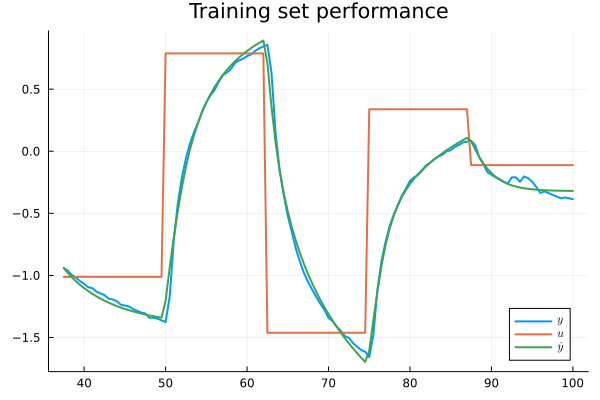

In [17]:
prediction_training = predict_NODE(student_w, training_prob, y_training[1] , tsteps_training, dt)[1,:]

p = plot(tsteps_training, y_training, label=L"y", lw =2, title="Training set performance")
plot!(p, tsteps_training, u_training, label=L"u", lw =2)
plot!(p, tsteps_training, prediction_training, label=L"\hat{y}", lw =2)

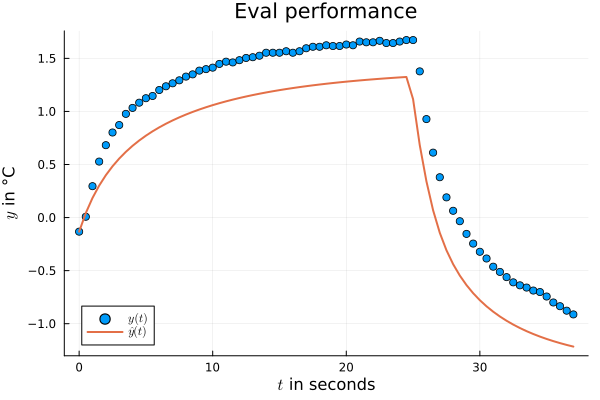

In [18]:
eval_plot = scatter(tsteps_eval, y_eval, label=L"$y(t)$", title="Eval performance", xlabel=L"$t$ in seconds", ylabel=L"$y$ in °C", legend=:bottomleft, lw=2)
plot!(eval_plot, tsteps_eval, prediction_eval, label=L"$\hat{y}(t)$", lw =2)

## Task 2: NODE model for Lake Erie (MIMO) - (4 points)

In this task, we once again model an underlying process using NODEs. However, the system at hand now takes multiple inputs $\mathbf{u}(t)$ and yields multiple outputs $\mathbf{y}(t)$. This means we need to model a multiple-input-multiple-output (MIMO) system.

This results in the dynamics equations 

$$
\begin{align}
    \frac{\mathrm{d}}{\mathrm{d}t} \hat{\mathbf{x}}(t) &= \mathcal{M}_{\mathbf{w}} (\hat{\mathbf{x}}(t), \mathbf{u}(t)) \\
    \hat{\mathbf{y}}(t) & = \hat{\mathbf{x}} (t).
\end{align}
$$

The data ([source](https://ftp.esat.kuleuven.be/pub/SISTA/data/environmental/) and [description](https://ftp.esat.kuleuven.be/pub/SISTA/data/environmental/erie.txt) of the dataset) is the result of a simulation of the western basin of Lake Erie. The inputs $\mathbf{u}(t)$ are the water temperature, water conductivity, water alkalinity, the NO3 content and the total hardness of the water. The outputs $\mathbf{y}(t)$ are the amount of dissolved oxigen and the algae content. We are interested in the dynamic relationship between inputs and outputs described by the model above.

#### a) - (1 point)

Below you are shown the raw output data:

![lake_erie-not_normalized](./LakeErie-NotNormalized.svg)

You can see that the two outputs are scaled very differently. As a result, we need to normalize them separately.

Implement the function below to normalize each output separately. Use `StatsBase.fit(ZScoreTransform, ...)` and `StatsBase.transform(...)` for the normalization.

In [19]:
function normalize_columnwise(data)

    #--- YOUR CODE STARTS HERE ---#
    #dt = StatsBase.fit(ZScoreTransform, data, dims=2)
    #normalized_data = StatsBase.transform(dt, data)
    normalized_data = similar(data)
    for i in 1:size(data, 2)
        column = data[:, i]
        dt =  StatsBase.fit(ZScoreTransform, column)
        normalized_data[:, i] = StatsBase.transform(dt, column)
    end
    #--- YOUR CODE ENDS HERE ---#
    
    return normalized_data
end

function loaddata_erie(; normalize= true)
    fh = GZip.open("erie.dat.gz")
    data = readdlm(fh)
    
    t = data[:, 1]  # time in months
    u = data[:, 2:6]
    y = data[:, 22:23]
    
    dt = 1  # time between samples in months
    
    # convert to Float32 for performance
    t = Float32.(t)
    u = Float32.(u) 
    y = Float32.(y)
    
    if normalize  # optional standardization of data
        y = normalize_columnwise(y)
        u = normalize_columnwise(u)
    end
    
    tspan = (t[1], t[end])
    
    return u, y, dt, tspan, t
end

loaddata_erie (generic function with 1 method)

Code for plot below when the data is normalized properly:
```
p = plot(tsteps, y, label=L"y", title="Lake Erie", xlabel=L"$t$ in months", ylabel=L"y", legend=:topleft, background_color="#000000",lw=2, palette = :Set2_5)
```

![lake_erie](./LakeErie.svg)

In [20]:
isa(normalize_columnwise, Function)


true

In [21]:
# please leave this cell as it is


#### Preparations:

In [22]:
u, y, dt, tspan, tsteps = loaddata_erie(normalize=true)

# interpolate inputs for all channels separately
interp_input = [AkimaInterpolation(u[:, i], tsteps) for i in 1:size(u, 2)]
function interpolate_input(t)
    return [f(t_) for (f, t_) in zip(interp_input, ones(size(interp_input, 1))* t)]
end

interpolate_input (generic function with 1 method)

In [23]:
belonging_to_training = tsteps .<= 40
belonging_to_eval = tsteps .> 40

u_training = u[belonging_to_training, :]
y_training = y[belonging_to_training, :]
tsteps_training = tsteps[belonging_to_training, :]

u_eval = u[belonging_to_eval, :]
y_eval = y[belonging_to_eval, :]
tsteps_eval = tsteps[belonging_to_eval, :];

tsteps_training = vec(tsteps_training)
tsteps_eval = vec(tsteps_eval);

#### **b)**

Build and train a NODE model using the training dataset. Design a feed-forward fully-connected neural network as the model.

In [24]:
result_2 = nothing

#--- YOUR CODE STARTS HERE ---#
input_size = size(y_training)[2] + size(u_training)[2]
output_size = size(y_training)[2]
ann = create_ann([input_size, 32, 24, output_size], tanh, x -> x)
seed = 2 
w, st = Lux.setup(MersenneTwister(seed), ann);
w = ComponentArray(w);


dxdt(x, w, t) = ann(vcat(x, Float32.(interpolate_input(t))), w, st)[1]
training_prob = ODEProblem(dxdt, y_training[1,:], (Float32(1.), Float32(40.0)), w)


optimizer = OptimizationFlux.Adam(1e-3)
maxiters = 2_000

function callback(state, l)
	state.iter % 100 == 0 && @printf "Iteration: %5d, Training loss: %.6e\n" state.iter l
	return false
end

function MSE(w)
    preds = predict_NODE(w, training_prob, y_training[1,:], tsteps_training, dt).u
    loss = Flux.mse(mapreduce(permutedims, vcat, preds), y_training)
    return loss
end
optf = Optimization.OptimizationFunction((w, t) -> MSE(w), Optimization.AutoZygote())
optprob = Optimization.OptimizationProblem(optf, w)


#result_erie = Optimization.solve(
#    optprob,
#    optimizer,
#    maxiters=maxiters,
#    callback=callback
#)
##--- YOUR CODE ENDS HERE ---#
#
#
#if @isdefined result_erie
#    serialize("model_task_2", result_erie)
#end

OptimizationProblem. In-place: true
u0: ComponentVector{Float32}(layer_1 = (weight = Float32[-0.07648466 -0.7553157 … -0.6079341 -0.6848314; 0.49762347 1.0771949 … 0.1595773 0.13112934; … ; 0.34458807 0.63396204 … -0.7177531 -0.016231705; -0.31864783 0.24341652 … -0.59919566 0.7607731], bias = Float32[0.13027826, 0.28889227, 0.2938022, -0.13973823, 0.15655164, 0.27461913, 0.026354577, 0.15309002, -0.2629121, -0.022051197  …  -0.07227871, 0.09109905, -0.14239253, 0.25796396, 0.07763732, 0.118789844, -0.25507408, 0.26785663, 0.051540833, -0.366068]), layer_2 = (weight = Float32[0.39028102 0.42968035 … 0.18918014 0.4296946; -0.45990267 -0.28261673 … -0.39583683 0.4443668; … ; -0.20279582 0.22392082 … -0.06989601 -0.17499152; -0.36452487 0.2800959 … 0.47370476 0.08412113], bias = Float32[0.16708617, 0.0057969196, -0.048955504, -0.078158505, 0.17549463, 0.024094552, -0.13024522, 0.08267648, 0.07520574, 0.07988088  …  0.05015083, 0.010449383, 0.013545112, -0.021434918, 0.0506968, -0.16342276

After you have trained your model, save the parameters using the code above into the file `model_task_2`. 

**Then comment out your optimization code in the cell above and remove your saving code so that both do not run in the autograding!**

**Ensure that everything that is necessary for the evaluation is still defined (Model definition etc.), i.e. that the evaluation can still run at submission!**

#### **c)** - (3 points)

Evaluate the performance of your model on the evaluation dataset. To do so, define the evaluation problem.

To gain the points for this subtask, you have to produce a model that reaches an MSE between the prediction and the eval trajectory lower than the threshold given below. Design a model architecture and optimization routine in the previous subtasks that reaches this level of accuracy.

In [25]:
result_erie = deserialize("model_task_2")
student_w = result_erie.u  # extract parameters

ComponentVector{Float32}(layer_1 = (weight = Float32[-0.1484459 -0.7543881 … -0.22185834 -0.6011546; 0.37805593 1.1761613 … 0.07303087 0.019772774; … ; 0.358723 0.60901886 … -0.6686199 0.20692237; -0.25049156 0.27470258 … -0.63900024 0.89539045], bias = Float32[0.06394215, 0.25969723, 0.30523884, -0.3607652, 0.31077763, 0.13023417, 0.0013742226, 0.113202475, -0.12368871, -0.07107374  …  -0.044185694, 0.0772053, -0.07746792, 0.12307627, 0.06238343, 0.09635387, -0.2905178, 0.171111, -0.06476445, -0.36474967]), layer_2 = (weight = Float32[0.43300498 0.3892557 … 0.14609607 0.42928246; -0.4874742 -0.25523663 … -0.36382478 0.4727521; … ; -0.22356524 0.24584892 … -0.04431494 -0.14787799; -0.38867104 0.30217946 … 0.49839175 0.10831969], bias = Float32[0.13787721, 0.036287043, -0.022586111, -0.14481547, 0.18214166, 0.0015501017, -0.18465015, 0.09615232, 0.10179539, 0.057844356  …  0.10006979, 0.015457212, 0.040934682, -0.052971642, 0.009252889, -0.13622624, -0.10889394, -0.17325427, -0.13125181

In [26]:
x0_eval = nothing
evaluation_prob = nothing

#--- YOUR CODE STARTS HERE ---#
x0_eval = y_eval[1,:]
evaluation_prob = ODEProblem(dxdt, x0_eval, (Float32(41.), Float32(57.)), student_w)
#--- YOUR CODE ENDS HERE ---#

ODEProblem with uType Vector{Float32} and tType Float32. In-place: false
timespan: (41.0f0, 57.0f0)
u0: 2-element Vector{Float32}:
 -1.333199
  0.5546457

In [27]:
#public test
@assert isa(x0_eval, Array)
@assert isa(evaluation_prob, ODEProblem)

prediction_eval = mapreduce(permutedims, vcat, predict_NODE(student_w, evaluation_prob, x0_eval, tsteps_eval, dt).u)


@assert length(prediction_eval) == length(y_eval)

prediction_error_eval = Flux.mse(prediction_eval, y_eval)
println("Given prediction error: ", prediction_error_eval)

@assert prediction_error_eval <= 0.5

Given prediction error: 0.3671688


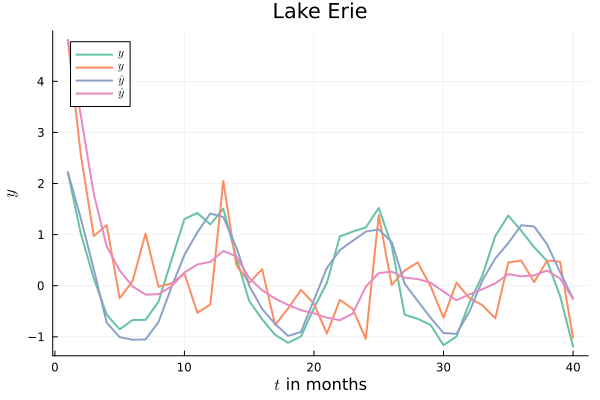

In [28]:
prediction_training = mapreduce(permutedims, vcat, predict_NODE(student_w, training_prob, y_training[1,:], tsteps_training, dt).u)

p = plot(tsteps_training, y_training, label=L"y", title="Lake Erie", xlabel=L"$t$ in months", ylabel=L"y", legend=:topleft,lw=2, palette = :Set2_5)
# plot!(p, tsteps_training, u_training, label=L"u", lw =2)
plot!(p, tsteps_training, prediction_training, label=L"\hat{y}", lw =2)

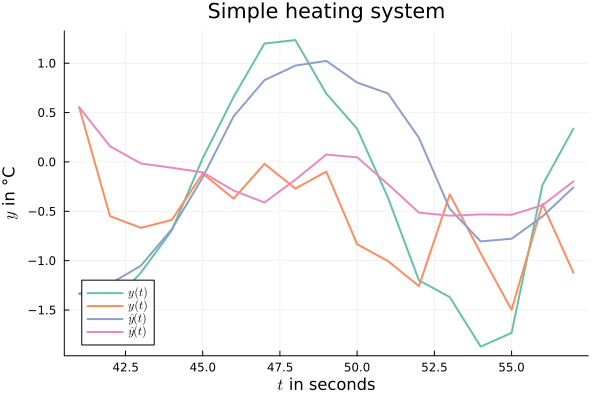

In [29]:
eval_plot = Plots.plot(tsteps_eval, y_eval, label=L"$y(t)$", title="Simple heating system", xlabel=L"$t$ in seconds", ylabel=L"$y$ in °C", legend=:bottomleft,lw=2, palette = :Set2_5)
Plots.plot!(eval_plot, tsteps_eval, prediction_eval, label=L"$\hat{y}(t)$", lw =2)
display(eval_plot)